# LOP - ACO

### Imports

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Solución aleatoria

In [5]:
def generar_solucion_aleatoria(n):
    """
    Genera una permutación aleatoria de tamaño n.
    Basado en la definición del espacio de búsqueda |Ω| = n!.
    """
    elementos = list(range(n))
    random.shuffle(elementos)
    
    return elementos

### Función objetivo

In [6]:
def funcion_objetivo_lop(matriz, permutacion):
    """
    Calcula la suma de las entradas por encima de la diagonal principal
    dada una permutación específica de filas y columnas.
    Objetivo: Maximizar esta suma.
    """
    n = len(permutacion)

    fitness = 0
    
    for i in range(n - 1):
        u = permutacion[i]
        
        for j in range(i + 1, n):
            v = permutacion[j]
            valor = matriz[u][v]
            
            fitness += valor
            
    return fitness



### Funicones ACO

In [7]:
def inicializa_modelo(n, valor_inicial=1.0):
    """
    Inicializa la matriz de feromonas con un valor base.
    """
    # Matriz n x n con valor_inicial
    tau = np.full((n, n), valor_inicial, dtype=float)
    return tau

def elegir_siguiente_nodo(actual, no_visitados, feromonas, matriz_lop, alpha=1.0, beta=1.0):
    """
    Elige el siguiente nodo basado en la regla de transición probabilística.
    """
    probabilidades = []

    for candidato in no_visitados:
        if actual is None:
            tau = 1.0
            eta = 1.0
        else:
            tau = feromonas[actual][candidato]
            eta = matriz_lop[actual][candidato] + 0.0001
    
        prob = (tau ** alpha) * (eta ** beta)
        probabilidades.append(prob)
    
    suma_probs = sum(probabilidades)
    if suma_probs == 0:
        probs_norm = [1.0 / len(no_visitados)] * len(no_visitados)
    else:
        probs_norm = [p / suma_probs for p in probabilidades]
    
    siguiente = random.choices(no_visitados, weights=probs_norm, k=1)[0]
    return siguiente

def nuevo_candidato(modelo, matriz_lop, alpha=1.0, beta=1.0):
    """
    Una hormiga construye una solución completa.
    modelo: Matriz de feromonas.
    matriz_lop: Matriz del problema.
    """
    n = modelo.shape[0]
    candidatos_disponibles = list(range(n))
    solucion = []

    primero = elegir_siguiente_nodo(None, candidatos_disponibles, modelo, matriz_lop, alpha, beta)
    solucion.append(primero)
    candidatos_disponibles.remove(primero)

    while candidatos_disponibles:
        actual = solucion[-1]
        siguiente = elegir_siguiente_nodo(actual, candidatos_disponibles, modelo, matriz_lop, alpha, beta)
        solucion.append(siguiente)
        candidatos_disponibles.remove(siguiente)
    
    return solucion

def evaporar(modelo, rho=0.1):
    """
    Reduce todas las feromonas por un factor (1 - rho).
    """
    modelo = modelo * (1 - rho)
    modelo = np.maximum(modelo, 0.0001)

    return modelo

def actualizar(soluciones, fitnesses, modelo, Q=100.0):
    """
    Refuerza las feromonas basándose en las soluciones encontradas.
    Q es una constante de refuerzo.
    """
    for i in range(len(soluciones)):
        sol = soluciones[i]
        fit = fitnesses[i]

        delta = Q  * fit

        for k in range(len(sol) - 1):
            u = sol[k]
            v = sol[k+1]
            modelo[u][v] += delta

    return modelo

def criterio_terminacion(iteracion_actual, max_iteraciones):
    return iteracion_actual >= max_iteraciones


### Ejecutar

In [8]:
def ejecutar(matriz_lop, num_hormigas, max_iteraciones, alpha=1.0, beta=2.0, rho=0.1):
    n = matriz_lop.shape[0]
    modelo = inicializa_modelo(n)

    mejor_solucion_global = None
    mejor_fitness_global = -1
    registro_fitness = []

    iteracion = 0
    while not criterio_terminacion(iteracion, max_iteraciones):
        soluciones_iteracion = []
        fitness_iteracion = []

        for _ in range(num_hormigas):
            sol = nuevo_candidato(modelo, matriz_lop, alpha, beta)
            fit = funcion_objetivo_lop(matriz_lop, sol)

            soluciones_iteracion.append(sol)
            fitness_iteracion.append(fit)

            if fit > mejor_fitness_global:
                mejor_fitness_global = fit
                mejor_solucion_global = sol

        modelo = evaporar(modelo, rho)
        modelo = actualizar(soluciones_iteracion, fitness_iteracion, modelo, Q=0.01)

        registro_fitness.append(max(fitness_iteracion))
        iteracion +=1
        
        if iteracion % 10 == 0:
            print(f"ITERACIÓN {iteracion}: Mejor fitness actual = {mejor_fitness_global}")
    
    return mejor_solucion_global, mejor_fitness_global, registro_fitness

Iniciando prueba de ACO para LOP...
ITERACIÓN 10: Mejor fitness actual = 94
ITERACIÓN 20: Mejor fitness actual = 94
ITERACIÓN 30: Mejor fitness actual = 94
ITERACIÓN 40: Mejor fitness actual = 94
ITERACIÓN 50: Mejor fitness actual = 94

Resultados Finales:
Mejor Solución encontrada (orden de índices): [2, 1, 4, 0, 3]
Mejor Fitness (suma triángulo superior): 94
Validación del cálculo de fitness: 94 (Debe ser igual al Mejor Fitness)


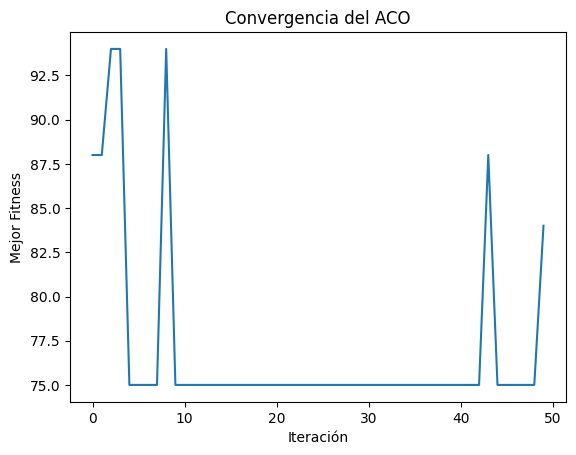

In [9]:

# --- 1. DATOS DE PRUEBA (Matriz Sintética 5x5) ---
# En LOP buscamos ordenar filas/cols para maximizar la suma del triángulo superior.
# Aquí ponemos valores altos estratégicos para ver si el algoritmo los encuentra.
matriz_prueba = np.array([
    [0,  1,  5, 20,  1],
    [10, 0,  1,  1, 15],
    [1, 20,  0,  1,  1],
    [1,  1, 10,  0,  1],
    [5,  1,  1, 20,  0]
])

# --- 2. PARÁMETROS ---
num_hormigas = 10
max_iteraciones = 50
alpha = 1.0  # Importancia de la feromona
beta = 2.0   # Importancia de la heurística (valores de la matriz)
rho = 0.1    # Evaporación

print("Iniciando prueba de ACO para LOP...")

# --- 3. EJECUCIÓN ---
# Nota: La función ejecutar() en tu código ya llama a inicializa, nuevo_candidato, etc.
mejor_sol, mejor_fit, historia_fitness = ejecutar(
    matriz_prueba, 
    num_hormigas, 
    max_iteraciones, 
    alpha, 
    beta, 
    rho
)

# --- 4. RESULTADOS ---
print("\nResultados Finales:")
print(f"Mejor Solución encontrada (orden de índices): {mejor_sol}")
print(f"Mejor Fitness (suma triángulo superior): {mejor_fit}")

# Validación simple: Verificar si el fitness devuelto coincide con el cálculo manual
fitness_validacion = funcion_objetivo_lop(matriz_prueba, mejor_sol)
print(f"Validación del cálculo de fitness: {fitness_validacion} (Debe ser igual al Mejor Fitness)")

# Opcional: Gráfica de convergencia
if len(historia_fitness) > 0:
    plt.plot(historia_fitness)
    plt.title("Convergencia del ACO")
    plt.xlabel("Iteración")
    plt.ylabel("Mejor Fitness")
    plt.show()